This is a small example showing how to use [fastai](https://www.fast.ai) to train on the original [MNIST](http://yann.lecun.com/exdb/mnist) dataset. This notebook aims to serve two purposes, first to demonstrate how to pass data in custom numpy data and second to show how quick it is to write code to train the data.

The MNIST dataset contains 70,000 handwritten digits from 0 to 9. 60,000 for training and 10,000 for testing. Each digit is a tiny grayscale 28x28 image.

For training I use a pre-trained resnet model and did transfer learning.

This Jupyter notebook can be downloaded here https://github.com/nghiaho12/fastai_projects/blob/main/mnist.ipynb 

# Table of Contents
1. [Load the MNIST data](#load)
2. [Visualize some the data](#viz)
3. [Custom Transform class](#transform)
4. [Setup Dataloaders](#dataloaders)
5. [Train the model](#train)
6. [Evaluate the model on the test set](#test_eval)
7. [Visualize misclassification](#viz_miss)
8. [Thoughts](#thoughts)

# 1. Load the MNIST data <a name="load"></a>
This will download the MNIST data if you don't have it already.

In [3]:
from fastai.vision.all import *
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import sys
import gzip

plt.style.use('dark_background')

print("torch.cuda.device_count():", torch.cuda.device_count())
print("torch.cuda.current_device():", torch.cuda.current_device())
print("torch.cuda.get_device_name(0):", torch.cuda.get_device_name(0))

if torch.cuda.is_available() == False:
    raise ValueError("No CUDA device found!")

def read_mnist_image(file):
    with gzip.open(file, 'r') as f:
        f.read(4) # magic number
        num_images = int.from_bytes(f.read(4), byteorder='big')
        image_height = int.from_bytes(f.read(4), byteorder='big')
        image_width = int.from_bytes(f.read(4), byteorder='big')

        buf = f.read(image_width * image_height * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, image_height, image_width)
        
        return data
    
def read_mnist_label(file):
    with gzip.open(file, 'r') as f:
        f.read(4) # magic number
        num_labels = int.from_bytes(f.read(4), byteorder='big')
        buf = f.read(num_labels)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)

        return data
    
# download dataset if it doesn't exist    
files = ['train-images-idx3-ubyte.gz', 
         'train-labels-idx1-ubyte.gz', 
         't10k-images-idx3-ubyte.gz', 
         't10k-labels-idx1-ubyte.gz']

for f in files:
    if not os.path.exists(f):        
        url = 'http://yann.lecun.com/exdb/mnist/' + f
        print(url)
        download_url(url, f)
        
train_image = read_mnist_image('train-images-idx3-ubyte.gz')
train_label = read_mnist_label('train-labels-idx1-ubyte.gz')
test_image = read_mnist_image('t10k-images-idx3-ubyte.gz')
test_label = read_mnist_label('t10k-labels-idx1-ubyte.gz')

print("train_image:", train_image.shape)
print("train_label:", train_label.shape)
print("test_image:", test_image.shape)
print("test_label:", test_label.shape)

torch.cuda.device_count(): 1
torch.cuda.current_device(): 0
torch.cuda.get_device_name(0): GeForce MX250
train_image: (60000, 28, 28)
train_label: (60000,)
test_image: (10000, 28, 28)
test_label: (10000,)


# Setup DataBlock

In [5]:
def make_dataloaders_from_numpy_data(np_image, label):
    def pass_index(idx):
        return idx

    def get_x(i):
        # NOTE: This is a grayscale image that appears to just work with a network expecting RGB.
        # I suspect this is due to tensor broadcasting rule.
        return np_image[i]

    def get_y(i):
        return label[i]

    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=pass_index,
        get_x=get_x,
        get_y=get_y)

    # pass in a list of index
    dls = dblock.dataloaders(list(range(np_image.shape[0])))

    return dls

dls = make_dataloaders_from_numpy_data(train_image, train_label)

# 5. Train model <a name="train">
Here I do transfer learning using a pre-trained resnet18 model.

In [191]:
learn = cnn_learner(dls, models.resnet18, n_out=10, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fine_tune(1)
learn.save("mnist_model")

epoch,train_loss,valid_loss,accuracy,time
0,0.796030,0.552081,0.822750,00:35


epoch,train_loss,valid_loss,accuracy,time
0,0.117518,0.081023,0.975083,01:00


Path('models/mnist_model.pth')

Accuracy is 99.25% after 5 iterations, pretty good!

# 6. Evaluate model on test set <a name="eval_test">
Load the saved model and perform inference on the test set. I've duplicated some code to demonstrate how to load the model at a later time. 

In [20]:
learn = cnn_learner(dls, models.resnet18, n_out=10, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn = learn.load("mnist_model")

pred = learn.get_preds(dl=dls.test_dl(test_image))
accuracy(pred[0], Tensor(test_label)).item()

0.9778000116348267

Good accuracy on the test set as well. For fun we can plot the confusion matrix and display some of the misclassification. You can see some of these digits are hard to recognize even for a human!

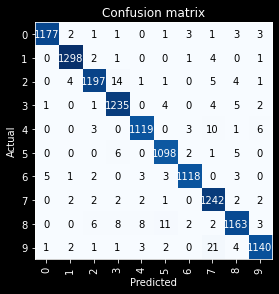

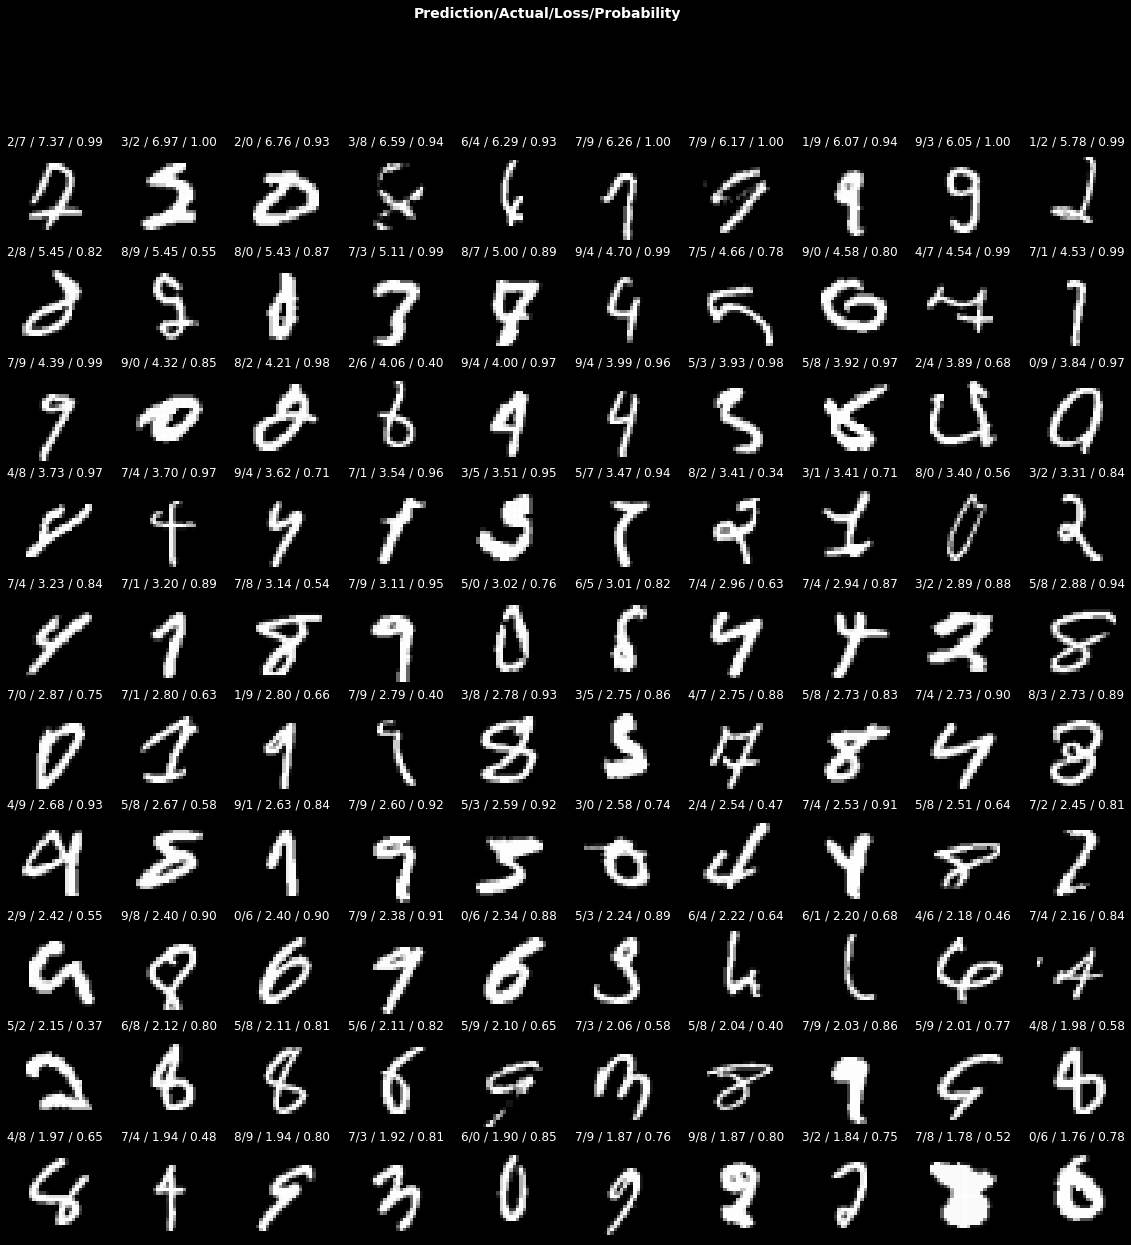

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(100, figsize=(20,20))

# 8. Thoughts <a name="thoughts"></a>
Getting the numpy array into fastai requires some custom code, which I found a bit painful to get working right initially, but that's probably due to my limited familiarity with the library. I've only started learning fastai and this is my first project using it. 

An annoying gotcha I came across was forgetting to call dls = dls.cuda(). Without this Pytorch will use the CPU instead. I didn't suspect anything until I ran the notebook on a more powerful GPU and noticed I was not getting any speedup!

MNIST is an old school dataset that is really easy to get near perfect results on without trying too hard. In this case I took a an existing pre-trained resnet18 model and performed some fine tuning. No further tricks were necessary. It also shows the power of transfer learning.